In [ ]:
# Установка пакета torchvision.
!pip3 install torchvision

# Набор данных MNIST

In [1]:
# Скачиваем датасет.
from torchvision import datasets

download_dir = "./dataset"

# Скачиваем обучающую выборку.
train_data = datasets.MNIST(root=download_dir, download=True, train=True)

# Скачиваем валидационную выборку (ВАЖНО - не используем её в обучении).
val_data = datasets.MNIST(root=download_dir, download=True, train=False)

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.73MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 150kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.76MB/s]


In [2]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train

In [9]:
# Объекты данных из обучающей выборки (60 000 чёрно-белых картинок размеров 28 x 28).
import copy

x_train = copy.deepcopy(train_data.data)[:, :, :, None] / 255.

print(x_train.shape, x_train.min(), x_train.max(), x_train.dtype, sep="\n")

torch.Size([60000, 28, 28, 1])
tensor(0.)
tensor(1.)
torch.float32


In [10]:
# Цели предсказания для обучающей выборки (60 000 чисел от 0 до 9).
y_train = copy.deepcopy(train_data.targets)

print(y_train.shape, y_train.min(), y_train.max(), y_train.dtype, sep="\n")

torch.Size([60000])
tensor(0)
tensor(9)
torch.int64


In [11]:
# Какому классу соответствуют цели от 0 до 9 (мы предсказываем цифры).
classes = train_data.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [12]:
classes_ru = [
    "0 - ноль",
    "1 - один",
    "2 - два",
    "3 - три",
    "4 - четыре",
    "5 - пять",
    "6 - шесть",
    "7 - семь",
    "8 - восемь",
    "9 - девять",
]

In [34]:
import pandas as pd

def get_unique(df: pd.DataFrame, stolbec):
    """
    Возвращает список замен и кол-во уникальных элементов в столбце
    """
    df_uniques = pd.melt(
        frame=df,
        value_vars=[stolbec],
    )
    df_uniques = (
        pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
        .sort_index(level=[0, 1])
        .rename(columns={"value": "count"})
        .reset_index()
    )
    return df_uniques
get_unique(pd.DataFrame(y_val),0)

,variable,value,count
0,0,0,980
1,0,1,1135
2,0,2,1032
3,0,3,1010
4,0,4,982
5,0,5,892
6,0,6,958
7,0,7,1028
8,0,8,974
9,0,9,1009


In [35]:
get_unique(pd.DataFrame(y_train),0)

,variable,value,count
0,0,0,5923
1,0,1,6742
2,0,2,5958
3,0,3,6131
4,0,4,5842
5,0,5,5421
6,0,6,5918
7,0,7,6265
8,0,8,5851
9,0,9,5949


In [31]:
# Аналогично записываем x и y для валидационной выборки (10 000 примеров).
x_val = copy.deepcopy(val_data.data)[:, :, :, None] / 255.
y_val = copy.deepcopy(val_data.targets)

print(x_val.shape, y_val.shape, sep="\n")

torch.Size([10000, 28, 28, 1])
torch.Size([10000])


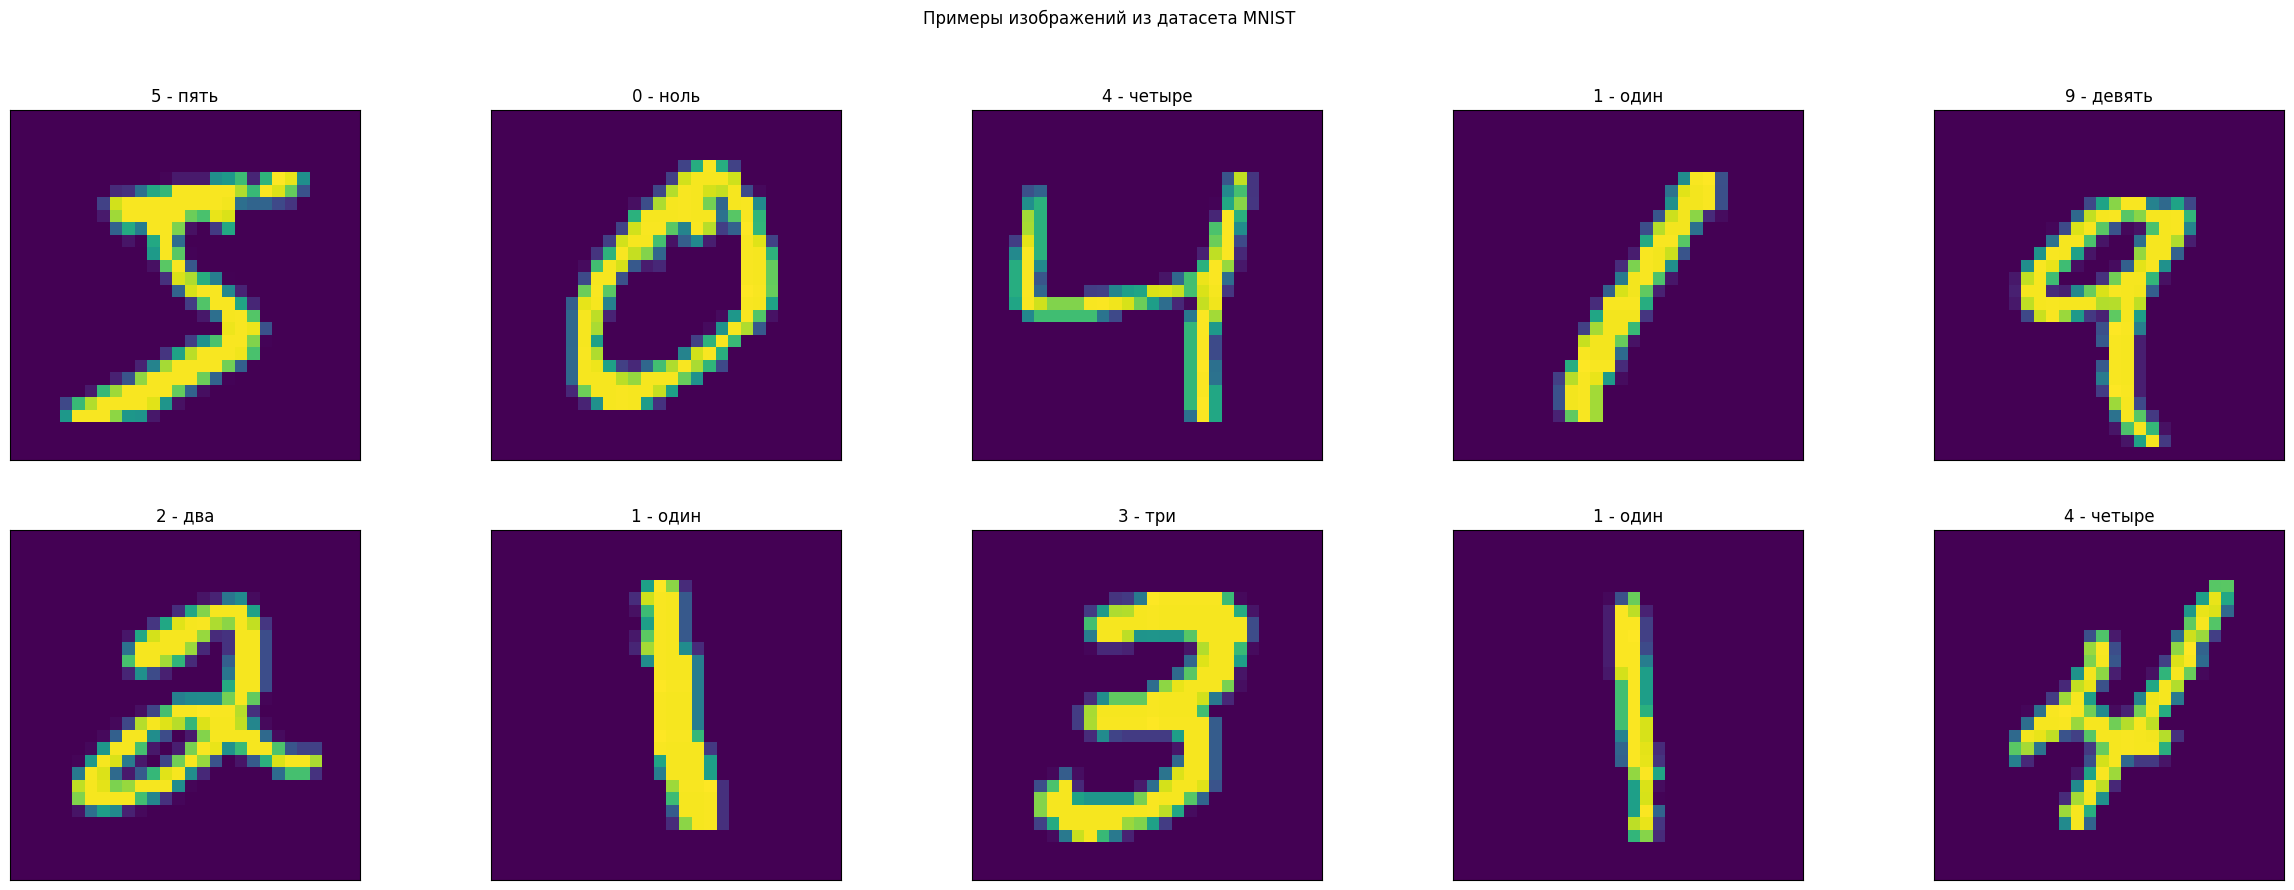

In [14]:
# Посмотрим на то, как выглядят картинки из датасета — рукописные цифры от 0 до 9.

import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 5 * hh))
fig.suptitle("Примеры изображений из датасета MNIST")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes_ru[y])
plt.show()

# Создание свёрточной нейронной сети

In [18]:
from torch.nn import Linear, Conv2d, ReLU, Softmax, MaxPool2d, Flatten, Sequential

In [51]:

le_net = Sequential(
    Conv2d(1,6,5,padding='same'),
    ReLU(),
    MaxPool2d(2),
    Conv2d(6,16,5),
    ReLU(),
    MaxPool2d(2),
    Conv2d(16,120,5),
    ReLU(),
    Flatten(),
    Linear(120,84),
    ReLU(),
    Linear(84,10),
    Softmax(-1)
)

In [52]:
def le_net_architecture_test():
    layers = list(le_net.children())
    
    c1 = layers[0]

    assert isinstance(c1, Conv2d)
    assert c1.in_channels == 1
    assert c1.out_channels == 6
    assert c1.kernel_size == (5, 5)
    assert c1.stride == (1, 1)
    assert c1.padding == 'same'
    
    a1 = layers[1]

    assert isinstance(a1, ReLU)
    
    mp1 = layers[2]

    assert isinstance(mp1, MaxPool2d)
    assert mp1.kernel_size == 2
    
    c2 = layers[3]

    assert isinstance(c1, Conv2d)
    assert c2.in_channels == 6
    assert c2.out_channels == 16
    assert c2.kernel_size == (5, 5)
    assert c2.stride == (1, 1)
    assert c2.padding == (0, 0)
    
    a2 = layers[4]

    assert isinstance(a2, ReLU)
    
    mp2 = layers[5]

    assert isinstance(mp2, MaxPool2d)
    assert mp2.kernel_size == 2
    
    c3 = layers[6]

    assert isinstance(c3, Conv2d)
    assert c3.in_channels == 16
    assert c3.out_channels == 120
    assert c3.kernel_size == (5, 5)
    assert c3.stride == (1, 1)
    assert c3.padding == (0, 0)
    
    a3 = layers[7]

    assert isinstance(a3, ReLU)
    
    f1 = layers[8]

    assert isinstance(f1, Flatten)
    
    l1 = layers[9]

    assert isinstance(l1, Linear)
    assert l1.in_features == 120
    assert l1.out_features == 84
    assert len(l1.bias) > 0
    
    a3 = layers[10]

    assert isinstance(a3, ReLU)
    
    l2 = layers[11]

    assert isinstance(l2, Linear)
    assert l2.in_features == 84
    assert l2.out_features == 10
    assert len(l2.bias) > 0

    a4 = layers[12]

    assert isinstance(a4, Softmax)
    assert a4.dim == -1
    
    print('Все тесты прошли успешно!')

In [53]:
le_net_architecture_test()

Все тесты прошли успешно!


# Обучение нейронной сети

In [54]:
import torch
print(torch.__version__)

2.6.0+cu126


In [55]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.le_net = le_net
        
    def forward(self, x):
        # В архитектуре LeNet5 на последнем слое используется функция активации Softmax,
        #  однако на практике ровно в таком виде эта функция активации используется редко.
        # Так как для обучения модели мы будем использовать стандартный loss — NLLLoss,
        #  нам потребуется преобразовать выход модели, применив логарифм к полученным
        #  с помощью Softmax вероятностям.
        return self.le_net(x.permute((0, 3, 1, 2))).log()

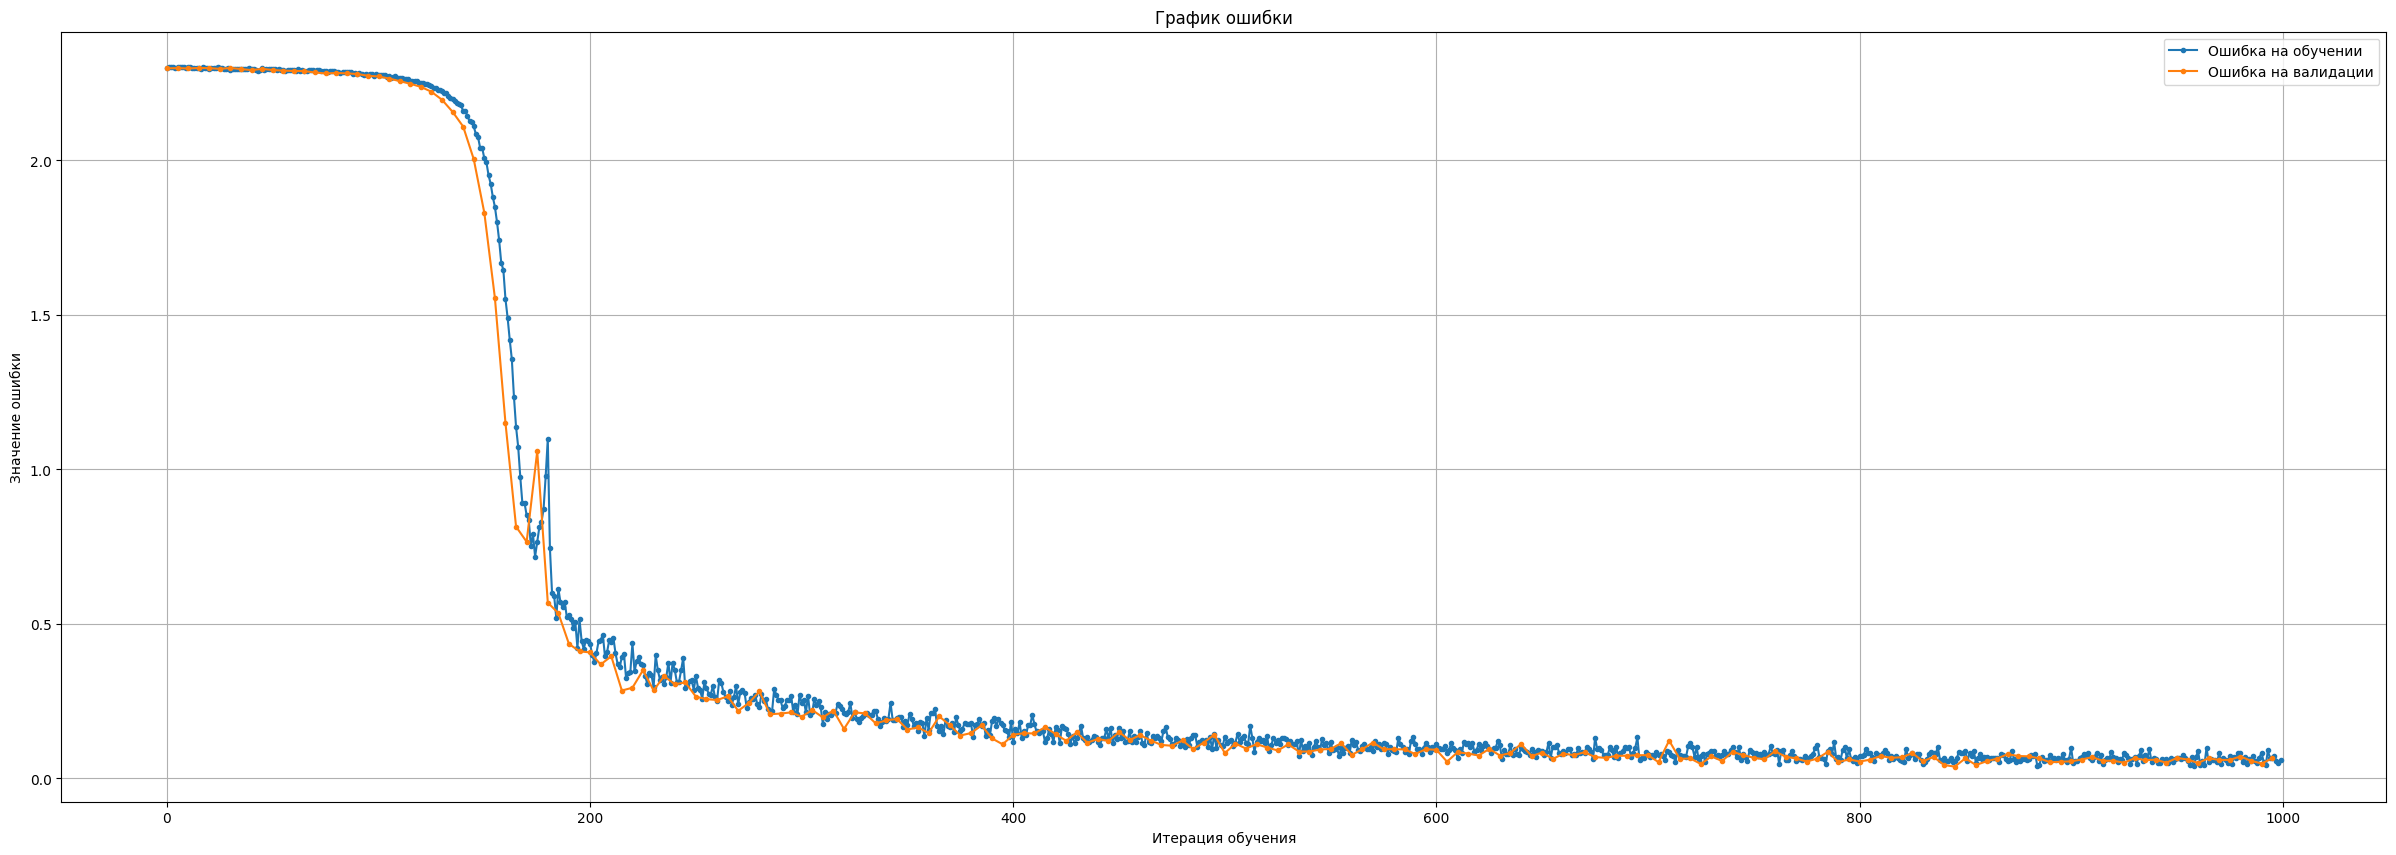

In [56]:
# Реализуем цикл обучения модели.
from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера
#  или виртуальной машины, если есть такая возможность.
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 1000
batch_size = 1000
val_every = 5

model = LeNet().to(dtype=x_train.dtype, device=device)  # Важно, чтобы все тензоры были одного типа и на одном устройстве.

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    # Дополнительные параметры оптимизатора,
    # ускоряющие процесс обучения.
    momentum=0.9,
    nesterov=True,
)

loss_fn = torch.nn.NLLLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    # Будем на каждой итерации обучения брать не все 50 000 картинок,
    #  а лишь случайные batch_size из них.
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])
    
    print(epoch)
    
    pred = model(x_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))
    
    loss.backward()
    optimizer.step()
    
    losses["train"].append(loss.item())
    
    # Каждые val_every итераций считаем значение loss на валидации.
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())
    
    # Каждые 100 итераций рисуем графики loss.
    if epoch % 10 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

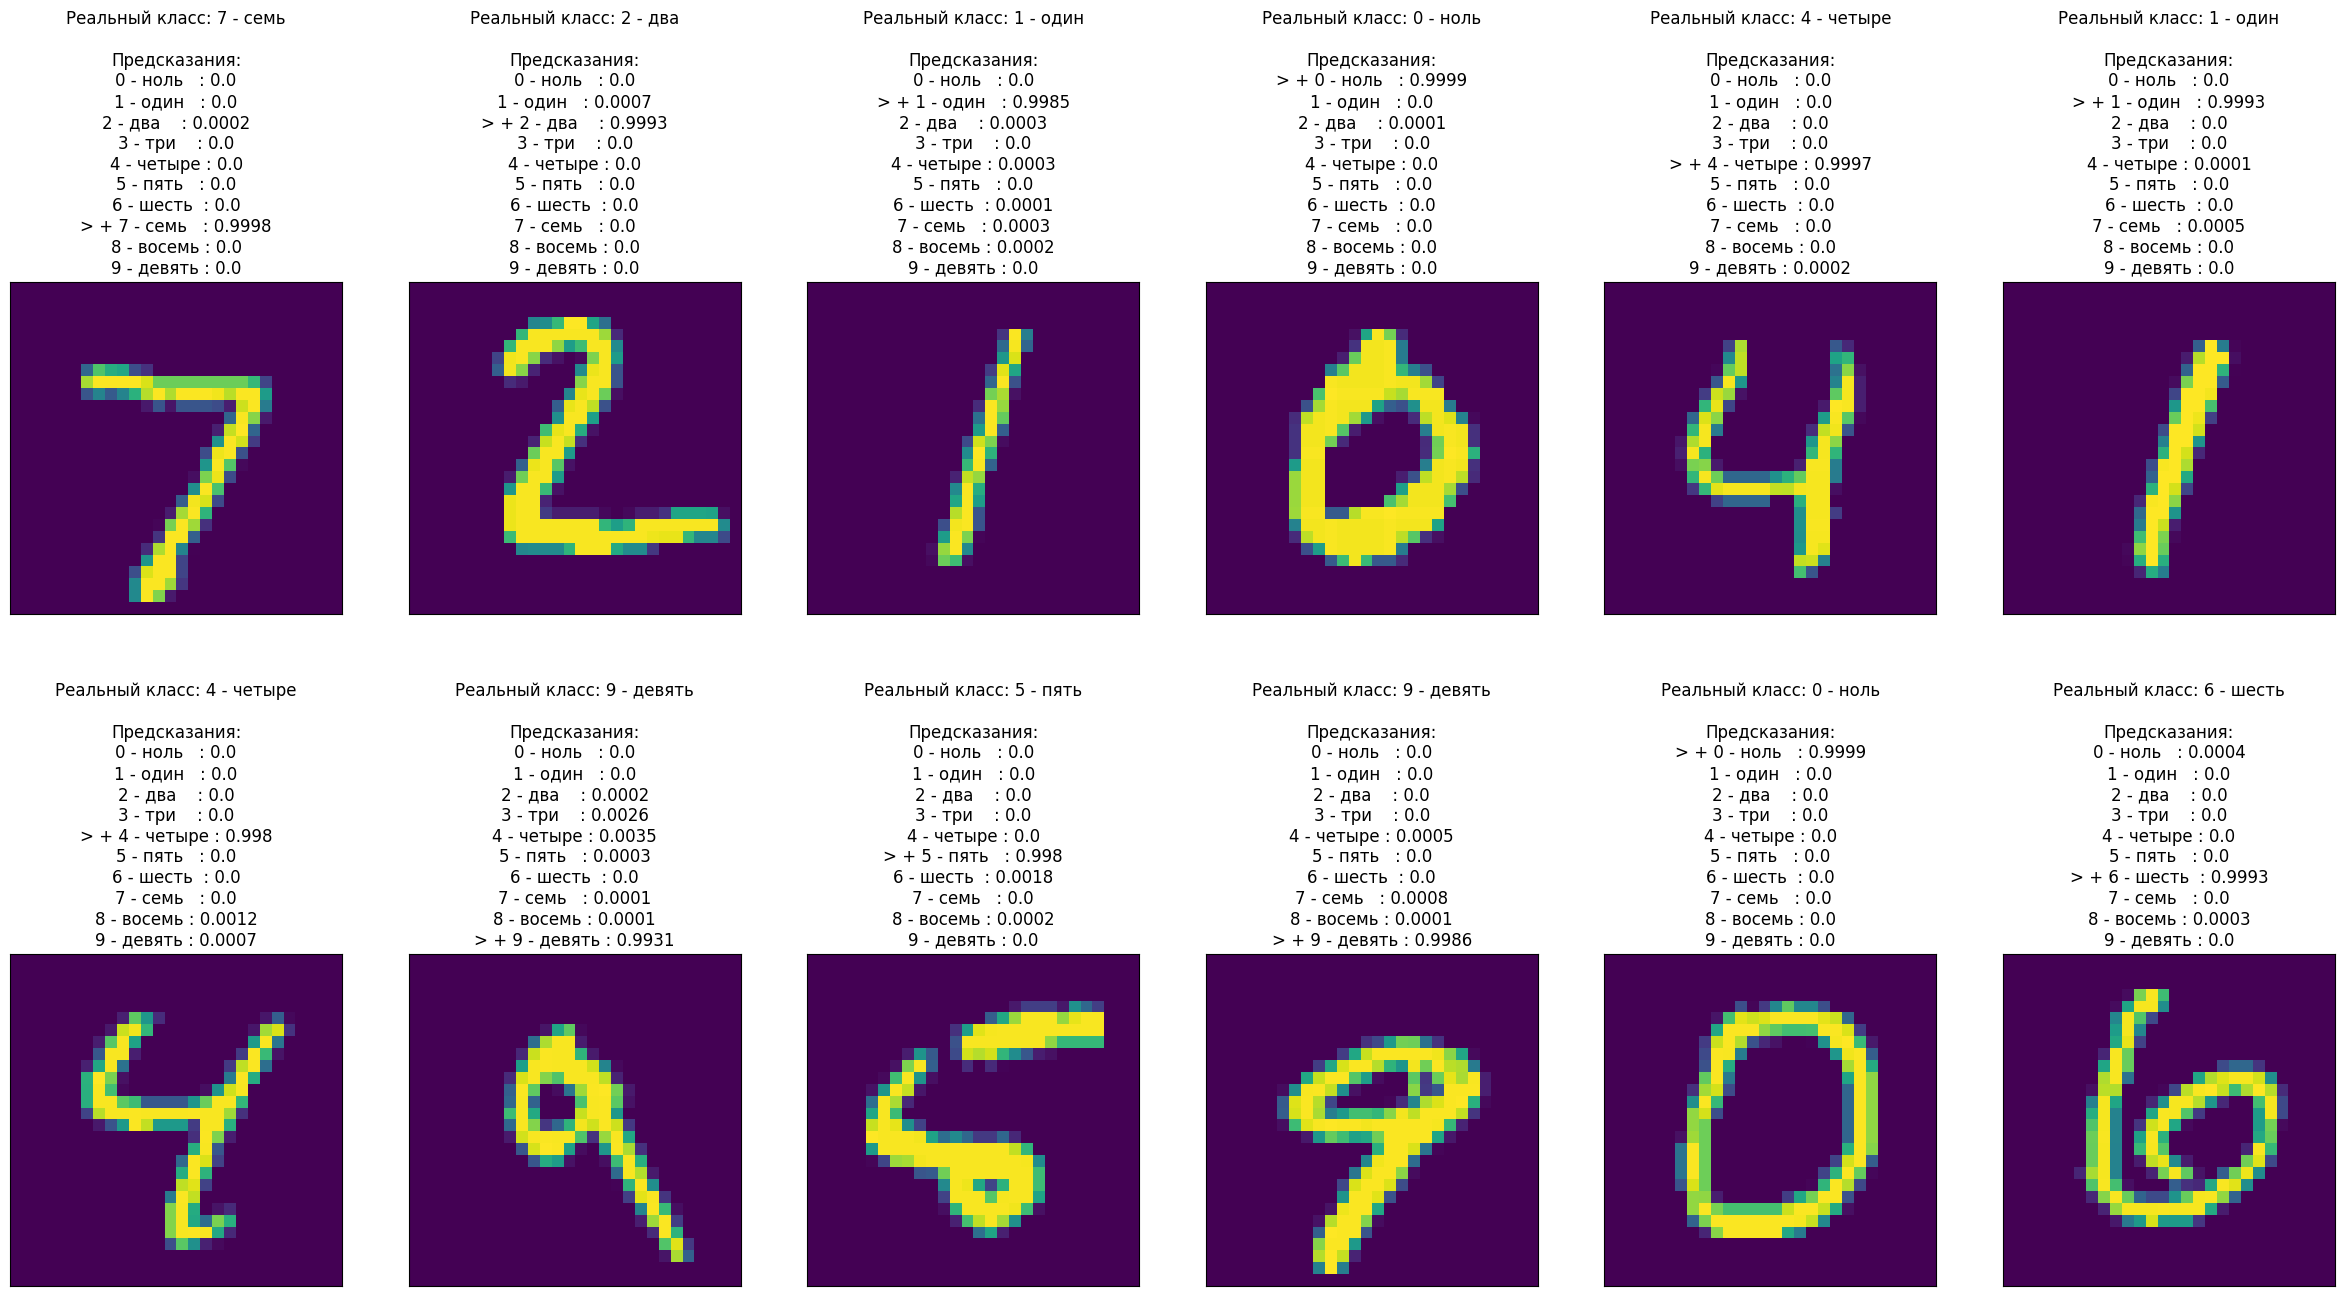

In [57]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки.
def show_results(model, h=2, w=6):
    with torch.no_grad():
        batch_probs = model(x_val[:h*w].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 8 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(x_val[i])
            title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )
                
            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

show_results(model, 2, 6)

## Оценка качества работы модели

In [58]:
with torch.no_grad():
    pred_sub = model(x_val.to(device)).max(1).indices
    acc_score = (y_val.to(device) == pred_sub).to(dtype=torch.float).mean().item()
    print('Доля правильно классифицированных изображений', round(acc_score, 2))

Доля правильно классифицированных изображений 0.98


In [59]:
x_loaded = torch.load(f"x_data_practice_3.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'x_data_practice_3.pt'

In [60]:
with torch.no_grad():
    pred_loaded = model(x_loaded.to(device)).max(1).indices.detach().cpu()

NameError: name 'x_loaded' is not defined

In [ ]:
def to_list(x, precision=2):
    return [round(x, precision) for x in x.tolist()]

#### Значение, которое нужно отправить в систему

In [ ]:
print(to_list(pred_loaded))